In [1]:
import sys
sys.path.append("..")

import numpy as np
import pandas as pd
# import matplotlib.pyplot as plt
# import seaborn as sns
from tqdm import tqdm
from sklearn.metrics.pairwise import rbf_kernel
# from scipy.spatial.distance import pdist
from Environment import AvgEnvironment
from Policy import MultinomialPolicy
from ParameterSelector import ParameterSelector
from Estimator_CPME import *
# import joblib
import os

import tensorflow as tf
print(tf.config.list_physical_devices('GPU'))

config = {
    "n_users": 30,
    "n_items": 20,
    "context_dim": 10,
    "n_reco": 5,
}

obs_size = 100
num_iter = 3
observation_sizes = [100, 1000, 5000]

def simulate_observation_size(obs_size, config, num_iter):
    results = []

    # === Generate environment ===
    user_vectors = np.random.normal(0, 1, size=(config["n_users"], config["context_dim"]))
    target_user_vectors = user_vectors * np.random.binomial(1, 0.5, size=user_vectors.shape)
    item_vectors = np.random.normal(0, 1, size=(config["n_items"], config["context_dim"]))

    alpha = -0.3
    logging_user_vectors = alpha * target_user_vectors

    logging_policy = MultinomialPolicy(item_vectors, logging_user_vectors, config["n_items"], config["n_reco"], temperature=0.5, cal_gamma=True)
    target_policy = MultinomialPolicy(item_vectors, target_user_vectors, config["n_items"], config["n_reco"], temperature=1.0, cal_gamma=False)
    environment = AvgEnvironment(item_vectors, user_vectors)

    seeds = np.random.randint(np.iinfo(np.int32).max, size=num_iter)

    for seed in tqdm(seeds, desc=f"Obs size {obs_size}"):
        np.random.seed(seed)

        # === Generate simulation data ===
        sim_data = []
        for _ in range(obs_size):
            user = environment.get_context()

            logging_reco, logging_multinomial, logging_user_vector = logging_policy.recommend(user)
            target_reco, target_multinomial, _ = target_policy.recommend(user)

            sim_data.append({
                "null_context_vec": logging_user_vector,
                "target_context_vec": logging_user_vector,
                "null_reco": tuple(logging_reco),
                "null_reco_vec": np.concatenate(item_vectors[logging_reco]),
                "null_reward": environment.get_reward(user, logging_reco),
                "target_reco": tuple(target_reco),
                "target_multinomial": target_multinomial,
                "target_reco_vec": np.concatenate(item_vectors[target_reco]),
                "target_reward": environment.get_reward(user, target_reco),
                "null_multinomial": logging_multinomial,
                "user": user,
            })

        sim_data = pd.DataFrame(sim_data)

        # === Prepare estimators ===
        # behavior_estimator = BehaviorPolicyEstimator(config["n_items"])
        # user_features = np.vstack(sim_data["null_context_vec"].values)
        # actions = [r[0] for r in sim_data["null_reco"].values]  # Taking first item as action

        # behavior_estimator.fit(user_features, actions)

        estimators = [
            IPSEstimator(logging_policy, target_policy, null_propensity_known = True),
            DirectEstimator(),
            DoublyRobustEstimator(logging_policy, target_policy, null_propensity_known = True),
            # CMEstimator(rbf_kernel, rbf_kernel, params=[5e-5, 1.0, 1.0]),
            # DRCMEstimator(rbf_kernel, rbf_kernel, [1e-3, 1.0, 1.0], logging_policy, target_policy), 
            CMEbis(rbf_kernel, rbf_kernel, params=[5e-5, 1.0, 1.0]),
            DoublyRobustbis(rbf_kernel, rbf_kernel, [5e-5, 1.0, 1.0], logging_policy, target_policy, null_propensity_known = True)
        ]

        # parameter selection
        direct_selector = ParameterSelector(estimators[1])  # direct estimator
        params_grid = [(n_hiddens, 1024, 100) for n_hiddens in [50, 100, 150, 200]]
        direct_selector.select_from_propensity(sim_data, params_grid, logging_policy, target_policy)
        estimators[1] = direct_selector.estimator
        
        estimators[2].params = direct_selector.parameters  # doubly robust estimator
        
        cme_selector = ParameterSelector(estimators[3])  # cme estimator
        # params_grid = [[(10.0 ** p) / config['n_observation'], 1.0, 1.0] for p in np.arange(-7, 0, 1)]
        params_grid = [[(10.0 ** p), 1.0, 1.0] for p in np.arange(-8, -1, 1)]
        cme_selector.select_from_propensity(sim_data, params_grid, logging_policy, target_policy)
        estimators[3] = cme_selector.estimator
        
        estimators[4].params = estimators[3]._params
        # === Prepare features for reward estimators ===
        logging_context_vec = np.vstack(sim_data["null_context_vec"].dropna().values)
        logging_reco_vec = np.vstack(sim_data["null_reco_vec"].dropna().values)
        logging_reward = sim_data["null_reward"].dropna().values

        X_logging = np.hstack([logging_context_vec, logging_reco_vec])

        # === Train reward models where needed ===
        for estimator in estimators:
            if isinstance(estimator, DirectEstimator):
                estimator.fit(X_logging, logging_reward, n_hidden_units=estimator.params[0], batch_size=1024, epochs=100)
            if isinstance(estimator, DoublyRobustEstimator):
                estimator.fit(X_logging, logging_reward)

        # === Calculate results ===
        actual_value = np.mean(sim_data["target_reward"])

        for estimator in estimators:
            est_value = estimator.estimate(sim_data)
            mse = (est_value - actual_value) ** 2
            results.append({
                "Estimator": estimator.name,
                "MSE": mse,
                "Observation Size": obs_size
            })

    return pd.DataFrame(results)


# Running the simulation
full_results = pd.concat(
    [simulate_observation_size(n, config, num_iter) for n in observation_sizes]
)

# full_results = joblib.Parallel(n_jobs=-1, verbose=0)(
#             joblib.delayed(simulate_observation_size)(n, config, num_iter) for n in observation_sizes
#         )

# Plotting results

# sns.set(style="whitegrid")
# plt.figure(figsize=(8, 5))
# sns.lineplot(
#     data=full_results, x="Observation Size", y="MSE", hue="Estimator", marker="o"
# )
# plt.yscale("log")
# plt.title("Number of Observations vs MSE")
# plt.tight_layout()
# plt.show()

2025-05-19 10:13:08.876526: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-19 10:13:10.352577: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747649591.151505 1500306 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747649591.441539 1500306 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1747649592.497877 1500306 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


2025-05-19 10:13:28.683777: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-19 10:13:28.683780: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-19 10:13:28.710404: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-05-19 10:13:28.711142: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been reg

[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   34.5s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   34.6s
[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done  11 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done  15 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:  3.6min
[Paralle

Obs size 100:   0%|          | 0/3 [00:00<?, ?it/s]/nfs/ghome/live/bbozkurt/.conda/envs/tensorenv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1747650003.457700 1500306 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 38484 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-40GB, pci bus id: 0000:31:00.0, compute capability: 8.0
I0000 00:00:1747650006.562167 1500406 service.cc:152] XLA service 0x7b4cd40153e0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1747650006.562191 1500406 service.cc:160]   StreamExecutor device (0): NVIDIA A100-SXM4-40GB, Compute Capability 8.0
2025-05-19 10:20:06.825041: I tensorflow/compiler/

/nfs/ghome/live/bbozkurt/.conda/envs/tensorenv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/nfs/ghome/live/bbozkurt/.conda/envs/tensorenv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/nfs/ghome/live/bbozkurt/.conda/envs/tensorenv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first

PARAMETER SELECTION IS DONE!
PARAMETER SELECTION IS DONE!


/nfs/ghome/live/bbozkurt/.conda/envs/tensorenv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/nfs/ghome/live/bbozkurt/.conda/envs/tensorenv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 264ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


Obs size 100:  33%|███▎      | 1/3 [01:11<02:23, 71.75s/it]/nfs/ghome/live/bbozkurt/.conda/envs/tensorenv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/nfs/ghome/live/bbozkurt/.conda/envs/tensorenv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/nfs/ghome/live/bbozkurt/.conda/envs/tensorenv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential

PARAMETER SELECTION IS DONE!
PARAMETER SELECTION IS DONE!


/nfs/ghome/live/bbozkurt/.conda/envs/tensorenv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/nfs/ghome/live/bbozkurt/.conda/envs/tensorenv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 254ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Obs size 100:  67%|██████▋   | 2/3 [02:19<01:09, 69.24s/it]/nfs/ghome/live/bbozkurt/.conda/envs/tensorenv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/nfs/ghome/live/bbozkurt/.conda/envs/tensorenv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/nfs/ghome/live/bbozkurt/.conda/envs/tensorenv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential

PARAMETER SELECTION IS DONE!
PARAMETER SELECTION IS DONE!


/nfs/ghome/live/bbozkurt/.conda/envs/tensorenv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/nfs/ghome/live/bbozkurt/.conda/envs/tensorenv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 241ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Obs size 100: 100%|██████████| 3/3 [03:26<00:00, 68.82s/it]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.



2025-05-19 10:23:29.955080: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-19 10:23:29.955080: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-19 10:23:29.992512: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-05-19 10:23:29.992546: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been re

[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   40.6s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   40.6s
[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done  11 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done  15 tasks      | elapsed:  3.7min
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:  3.7min
[Paralle

Obs size 1000:   0%|          | 0/3 [00:00<?, ?it/s]/nfs/ghome/live/bbozkurt/.conda/envs/tensorenv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/nfs/ghome/live/bbozkurt/.conda/envs/tensorenv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/nfs/ghome/live/bbozkurt/.conda/envs/tensorenv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models

PARAMETER SELECTION IS DONE!
PARAMETER SELECTION IS DONE!


/nfs/ghome/live/bbozkurt/.conda/envs/tensorenv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/nfs/ghome/live/bbozkurt/.conda/envs/tensorenv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 86ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


Obs size 1000:  33%|███▎      | 1/3 [01:17<02:34, 77.22s/it]/nfs/ghome/live/bbozkurt/.conda/envs/tensorenv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/nfs/ghome/live/bbozkurt/.conda/envs/tensorenv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/nfs/ghome/live/bbozkurt/.conda/envs/tensorenv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequentia

PARAMETER SELECTION IS DONE!
PARAMETER SELECTION IS DONE!


/nfs/ghome/live/bbozkurt/.conda/envs/tensorenv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/nfs/ghome/live/bbozkurt/.conda/envs/tensorenv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


Obs size 1000:  67%|██████▋   | 2/3 [02:37<01:18, 78.81s/it]/nfs/ghome/live/bbozkurt/.conda/envs/tensorenv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/nfs/ghome/live/bbozkurt/.conda/envs/tensorenv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/nfs/ghome/live/bbozkurt/.conda/envs/tensorenv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequentia

PARAMETER SELECTION IS DONE!
PARAMETER SELECTION IS DONE!


/nfs/ghome/live/bbozkurt/.conda/envs/tensorenv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/nfs/ghome/live/bbozkurt/.conda/envs/tensorenv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


Obs size 1000: 100%|██████████| 3/3 [03:55<00:00, 78.67s/it]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.



2025-05-19 10:34:07.614748: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-19 10:34:07.614749: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-19 10:34:07.656401: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-05-19 10:34:07.656400: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been re

[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   41.2s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   41.3s
[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done  11 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done  15 tasks      | elapsed:  3.7min
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:  3.7min
[Paralle

Obs size 5000:   0%|          | 0/3 [00:00<?, ?it/s]/nfs/ghome/live/bbozkurt/.conda/envs/tensorenv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/nfs/ghome/live/bbozkurt/.conda/envs/tensorenv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/nfs/ghome/live/bbozkurt/.conda/envs/tensorenv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models

PARAMETER SELECTION IS DONE!
PARAMETER SELECTION IS DONE!


/nfs/ghome/live/bbozkurt/.conda/envs/tensorenv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/nfs/ghome/live/bbozkurt/.conda/envs/tensorenv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


Obs size 5000:  33%|███▎      | 1/3 [03:37<07:14, 217.33s/it]/nfs/ghome/live/bbozkurt/.conda/envs/tensorenv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/nfs/ghome/live/bbozkurt/.conda/envs/tensorenv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/nfs/ghome/live/bbozkurt/.conda/envs/tensorenv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequenti

PARAMETER SELECTION IS DONE!
PARAMETER SELECTION IS DONE!


/nfs/ghome/live/bbozkurt/.conda/envs/tensorenv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/nfs/ghome/live/bbozkurt/.conda/envs/tensorenv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


Obs size 5000:  67%|██████▋   | 2/3 [07:16<03:38, 218.69s/it]/nfs/ghome/live/bbozkurt/.conda/envs/tensorenv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/nfs/ghome/live/bbozkurt/.conda/envs/tensorenv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/nfs/ghome/live/bbozkurt/.conda/envs/tensorenv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequenti

PARAMETER SELECTION IS DONE!
PARAMETER SELECTION IS DONE!


/nfs/ghome/live/bbozkurt/.conda/envs/tensorenv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/nfs/ghome/live/bbozkurt/.conda/envs/tensorenv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


Obs size 5000: 100%|██████████| 3/3 [10:58<00:00, 219.34s/it]


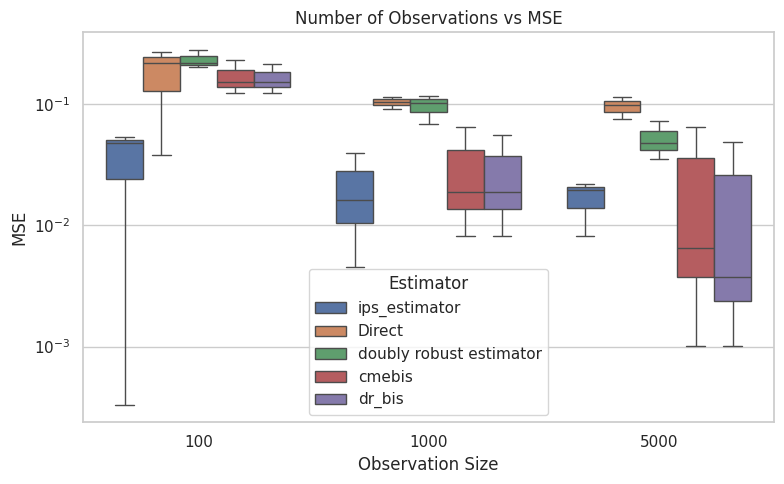

In [4]:
# Plotting results

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")
plt.figure(figsize=(8, 5))
sns.boxplot(
    data=full_results, x="Observation Size", y="MSE", hue="Estimator", 
    # marker="o"
)
plt.yscale("log")
plt.title("Number of Observations vs MSE")
plt.tight_layout()
plt.show()